#### The final project
Last one baybee

### What's going on in here?
I play too much DotA 2. I have spent approximately 5,000 hours just playing the game, not to mention the countless hours I've spent watching and studying it. That's not a flex, I'm not good or anything, but a testament to the degree to which my life could be better if I had never found the game. Anyway, I'm going to take advantage of it for the first time in my whole life and use some DotA datA to complete this project.  

#### A little background on DotA
Here's the website for reference: https://dota2.com. Top-down mouse-movement MOBA (multiplayer online battle arena) RTS (real-time strategy). If you've heard of League of Legends, it's basically League for *cultured* people. Two teams of five players first spend a few minutes drafting "heroes", each player selecting a unique hero. They are dropped into their team's base on opposite sides of a big map and they have to kill stuff to get more money to kill more stuff until they can kill the big rock in the other team's base. Best game ever made.  

My approach was honestly first seeing what data was convenient to get, then deciding what conclusions I could draw from it. Valve, the company that makes DotA 2 (one of the most profitable companies in the entire world) records basically every point of data from every frame of the match for every match. There is a way to get the data straight from them but it involves getting an API key and sacrificing a goat and I just ran out of goats trying to win my last ranked game.   

I've long known about OpenDota, a match analysis and statistics platform for analysing the game. They have an API (docs: https://docs.opendota.com/) that probably hasn't been updated beyond upkeep in the last 5 years. In spite of that and Valve's notorious spaghetti code, I was able to get the data I needed out of it because they have a `/explorer` call that lets me make arbitrary queries to their database. That sounds risky for them to offer but I'm glad they do because all the rest of their calls kinda blow. You can get 100 random matches but it's almost always the same 100. In spite of my insult, I think highly of them because of their extremely generous rates. You don't need an API key to make 50k requests a month or 60 requests a minute. Great for me, because I only have to make a handful of requests since they'll let me basically dump their database over the internet into my computer.   

Let's get into the nitty-gritty. Some libraries I imported straight away, some libraries I'll import as the project goes on. For a full list... read the full article >:}. `requests` to send requests to OpenDota's API, `pandas` to shuffle data around, `json` to parse their JSON responses, `urllib` because their `/explorer` call wants "percent-encoded strings" and it does that so I don't have to.  

In [4]:
import requests
import pandas as pd
import json
import urllib

So while I was wandering around their docs pretending I'm a capable adult who knows what he's doing, I tripped and fell over this `/schema` thing. After a bit of poking around, testing their other calls and finding out how relatively useless they are, and sobbing in the corner, I figured out that `/explorer` and `/schema` let me basically do whatever I want. Let's see what their database looks like.

In [5]:
schema_response = requests.get("https://api.opendota.com/api/schema")


In [45]:
schema_parsed = json.loads(schema_response.content)
schema_df = pd.DataFrame(schema_parsed)
for index, table in schema_df.groupby("table_name"):
    print("Table name: " + str(index))
    #print(table["column_name"]) # use this line to see all cols in all tables

Table name: api_key_usage
Table name: api_keys
Table name: competitive_rank
Table name: cosmetics
Table name: hero_ranking
Table name: hero_search
Table name: heroes
Table name: items
Table name: leaderboard_rank
Table name: leagues
Table name: match_gcdata
Table name: match_logs
Table name: match_patch
Table name: matches
Table name: mmr_estimates
Table name: notable_players
Table name: parsed_matches
Table name: picks_bans
Table name: player_matches
Table name: player_ratings
Table name: players
Table name: public_matches
Table name: public_player_matches
Table name: queue
Table name: rank_tier
Table name: rank_tier_2019_1
Table name: scenarios
Table name: solo_competitive_rank
Table name: subscriptions
Table name: team_match
Table name: team_rating
Table name: team_scenarios
Table name: teams
Table name: user_usage
Table name: webhooks


Now you don't have to do this, but I had that line up there uncommented and looked into the tables that had promising names for data I thought might be interesting. The following is a list of tables that seemed potentially useful for getting data about the average dota player's experience:
##### tables of note:
* competitive_rank: stores data about players' rankings in some system. Not the game's normal ranked "MMR" (matchmaking rating, measure of skill).
* heroes: stores mostly useless constant data about all of the heroes
* items: stores mostly useless constant data about all of the items the heroes can buy to get better at killin
* match_logs: has logs from matches. Almost too rich, has data on objective kills, teamfights etc. Lots of insight here.
* match_path: has matchID and patch cols, I guess it's for getting the patch of a match. Not needed, I'll just take data by time which guarantees a single patch.
* matches: has match data for tournament games
* parsed_matches: has matchIDs of parsed matches (OpenDota parses some matches by requesting and transforming data from Valve)
* player_matches: has like a million columns. Contains data about players in match (items they bought and when, etc). Useful, but bloated.
* players: has mildly interesting data about players but doesn't seem to have much on their matches
* public_matches and player_public_matches: seem to have the data I want.
* scenarios: seems to have heroes and item timings? Honestly the cols don't do me a lot of good here  

After looking over all of these, it seemed like the best choice for getting a lot of data and getting useful data was "public_matches". 

In [7]:
schema_df[schema_df["table_name"] == "public_matches"]

,table_name,column_name,data_type
271,public_matches,match_id,bigint
272,public_matches,match_seq_num,bigint
273,public_matches,radiant_win,boolean
274,public_matches,start_time,integer
275,public_matches,duration,integer
276,public_matches,avg_mmr,integer
277,public_matches,num_mmr,integer
278,public_matches,lobby_type,integer
279,public_matches,game_mode,integer
280,public_matches,avg_rank_tier,double precision


Some of these columns I knew right away just based on their names and values, others were more nuanced, and others I still don't know.
* `match_id` is a unique number that represents a particular match. 
* `match_seq_num` seems to indicate the sequence in which matches took place, which really doesn't matter to me because of other cols.
* `radiant_win` is boolean, says if one of the teams won. There can only be two outcomes, either Radiant wins or Dire wins.
* `start_time` is a timestamp down to the second for when the match started.
* `duration` is the duration of the match in seconds.
* `avg_mmr` seems to be the average mmr of the match, but there's a lot of reasons why it's more complicated than that. More on that later.
* `num_mmr` I spent hours failing to figure this one out, more on that later as well.
* `lobby_type` is the type of lobby the match was hosted in. More on that.
* `game_mode` is the type of game played in the lobby. M O T.
* `avg_rank_tier` honestly no idea, don't care. Doesn't seem more useful than `avg_mmr`.
* `num_rank_tier` presumably the `num_mmr` of `avg_rank_tier`. Don't know don't care.
* `cluster` at first I thought this was useless or an artifact of their database software, turns out it's the number ID of the server cluster the match is played on, a perfect analog for "region".  
  
After considerably faffing about trying to remember how to use SQL and sending goofy requests to their API I learned a few things. First is that there are somewhere in the neighborhood of 16 million matches in the table I want. I wanted all of them, but then realized I wanted them all to be from the same game patch (patches change the balance of the game and can mess with my analysis). I looked over the update news and saw that there was no balance patch in April, so I just found the unicode timestamps for the start and end of April this year (down to the second) and grabbed stuff that was in that range. There seems to be some number of rows that their database refuses to send to me in a single request, so I guessed and checked and it turns out I can get the ~3 million rows for April in about four chunks. Your mileage may vary trying to run this code, if you're getting 400 response codes just try a smaller chunk of matches.   
I basically just kept grabbing non-overlapping chunks of their table by the `start_time` of the matches until I had all of them, then I asked pandas to combine all of the dataframes and used SQLite to save them to my hard disk so I wouldn't have to mess around with remaking these requests every time I reopened my editor.  
  
That's the overall plot, below are some commented code sections that document my torment trying to get the stars aligned. It was hard to tell if my queries were failing because they were malformed or because I was asking for something the database didn't want to deliver, but I worked it out through brute force. If I had every request I made here this thing would take up at least another page without having more info, so I've cut down the actual work I did here for presentation pizzaz. 

In [8]:
# database_request = urllib.parse.quote("select * from matches limit 5".encode("utf8")) # seems to be capable of drawing really old matches, found one from 2012
# turns out "matches" has tournament matches and since there's so few it seems to have literally all of them since the game was released?
# database_request = urllib.parse.quote("select * from public_matches where start_time > 1651377600".encode("utf8"))
# ^^^^ above I tried grabbing all matches since the end of April (this was on like 5/3 so I knew there wouldn't be many)
# the above two requests helped me realize I could request large chunks of matches; that I was being limited by the chunk size

# I wondered how far back the public_matches table went, so I used this query:
# database_request = urllib.parse.quote("SELECT match_id FROM public_matches WHERE start_time = ( SELECT MIN(start_time) FROM public_matches ) ORDER BY match_id ASC LIMIT 1;".encode("utf8"))
# turns out they only went back about 6 months. So average of ~3 million matches a month so far this year. Nice.


# start of april this year 1648785600
# end of april this year 1651377600
# how many matches happened in April?
database_request = urllib.parse.quote("SELECT COUNT(*) FROM public_matches where start_time BETWEEN 1648785600 AND 1651377600".encode("utf8"))
print(database_request) # what does this SQL string look like?
request_string = "https://api.opendota.com/api/explorer?sql=" + database_request
print(request_string) # what's the request string look like?
api_response = requests.get(request_string)
print(api_response.status_code) # what's the status of the request?
api_parsed_json = json.loads(api_response.content)
print(api_parsed_json.keys())
print("Number of rows in April: " + str(api_parsed_json["rows"][0]["count"]))
# run without limiting timeframe there's 17 million matches in the table

SELECT%20COUNT%28%2A%29%20FROM%20public_matches%20where%20start_time%20BETWEEN%201648785600%20AND%201651377600
https://api.opendota.com/api/explorer?sql=SELECT%20COUNT%28%2A%29%20FROM%20public_matches%20where%20start_time%20BETWEEN%201648785600%20AND%201651377600
200
dict_keys(['command', 'rowCount', 'oid', 'rows', 'fields', '_parsers', '_types', 'RowCtor', 'rowAsArray', 'err'])
Number of rows in April: 2726818


Below you can see me poop-knifing (technical term) the data to try and get it to go through. I just updated the code in the request chunk with the various timestamps, but for you I've arranged it into a series of requests so that you can easily follow along if you want. Ain't I sweet? Like a said earlier, the database seems tempermental about these requests so you still might end up having to reduce the size of some slices by lowering the time gap you're requesting. Worst comes to worst, shoot me an email at jacksonpielstick@gmail.com and I'll link you my sqlite DB. It takes me around a minute to run this code, you should see requests coming back every 10-20 seconds in your output.

In [9]:
# I'm just gonna try breaking it into progressively smaller chunks until it goes through
# start of april this year   1648785600
# end of april this year     1651377600

# first end timestamp  =     1649433600
# second end timestamp =     1650100000
# third end timestamp  =     1650600000
# fourth end timestamp =     1651077600


chunk_request1 = urllib.parse.quote("SELECT * FROM public_matches where start_time BETWEEN 1651077600 AND 1651377600".encode("utf8"))
chunk_request2 = urllib.parse.quote("SELECT * FROM public_matches where start_time BETWEEN 1651077600 AND 1651377600".encode("utf8"))
chunk_request3 = urllib.parse.quote("SELECT * FROM public_matches where start_time BETWEEN 1651077600 AND 1651377600".encode("utf8"))
chunk_request4 = urllib.parse.quote("SELECT * FROM public_matches where start_time BETWEEN 1651077600 AND 1651377600".encode("utf8"))
chunk_requests = [chunk_request1, chunk_request2, chunk_request3, chunk_request4]

# accumulator df
mega_df = pd.DataFrame()

for req in chunk_requests:
    print(req) # SQL string
    chunk_request_string = "https://api.opendota.com/api/explorer?sql=" + req
    print(chunk_request_string) # API string
    chunk_response = requests.get(chunk_request_string)
    print(chunk_response) # response code
    chunk_parsed_json = json.loads(chunk_response.content)
    chunk_df = pd.DataFrame(chunk_parsed_json["rows"])
    mega_df = pd.concat([mega_df, chunk_df])

print("Number of rows: " + str(len(mega_df)))
mega_df.sample(10)

SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
https://api.opendota.com/api/explorer?sql=SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
<Response [200]>
SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
https://api.opendota.com/api/explorer?sql=SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
<Response [200]>
SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
https://api.opendota.com/api/explorer?sql=SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
<Response [200]>
SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%20AND%201651377600
https://api.opendota.com/api/explorer?sql=SELECT%20%2A%20FROM%20public_matches%20where%20start_time%20BETWEEN%201651077600%

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster
96641,6545705614,5467890710,False,1651174747,2942,4053.0,1.0,7,22,51,6,181
177939,6547112605,5469134098,True,1651259558,2633,NaN,NaN,7,22,34,5,181
79795,6545433317,5467630992,True,1651162373,1597,3510.0,2.0,7,22,42,5,153
134729,6546340802,5468456601,True,1651228309,2362,2851.0,1.0,7,22,29,2,155
159061,6546803302,5468838920,False,1651246682,1728,3584.0,3.0,7,22,61,6,153
241282,6548218604,5470108288,False,1651325689,1941,NaN,NaN,7,22,13,2,187
212865,6547677905,5469645775,False,1651301420,2491,NaN,NaN,7,22,14,2,152
238260,6548160712,5470059998,False,1651323695,1900,3825.0,2.0,7,22,36,6,155
71243,6545286916,5467512088,True,1651156788,1992,3739.0,3.0,7,3,42,8,227
101399,6545775808,5467945018,False,1651179087,2911,3573.0,5.0,7,22,61,6,187


Alright so that's our dataset in memory (probably also on disk? pandas is handling it so I don't have to). 2.7 million matches of DotA 2. Let's get it saved to disk before something explodes. Using `sqlite3` because it's an easy, local, compact database and it plays nice with pandas.

In [10]:
import sqlite3

In [11]:
database = "./dootaboose.sqlite"
conn = sqlite3.connect(database)
mega_df.to_sql(name='PublicMatchesApril', con=conn)
conn.close()

WOOOO! SAFE. Okay, now whenever we want to draw the data out of the database we can use the commented-out code below. There is technically an issue with the index getting copied into a new column. It's probably as easy as adding an argument to read_sql() to fix that, but I don't wanna fool with it. It's techincally not necessary to save the database to follow along here, just good practice.

In [12]:
# database = "./dootaboose.sqlite"
# conn = sqlite3.connect(database)
# mega_df =  pd.read_sql("select * from PublicMatchesApril", con=conn)
# conn.close()

Here I was doing a little warm-up exploratory analysis. I wanted to make sure that my data seemed reasonable in case I made some mistake grabbing it. Here I get the total number of matches, the number of Radiant and Dire wins, and their winrates. If they didn't add up to 100%, I'd have known that there was something strange about the data.

In [13]:
# mega_df["radiant_win"].isnull().sum()
print("Matches: " + str(mega_df["radiant_win"].count()))
print("Radiant Wins: " + str(mega_df["radiant_win"].sum()))
print("Dire Wins: " + str(mega_df["radiant_win"].count() - mega_df["radiant_win"].sum()))
print("Radiant Winrate: " + str(mega_df["radiant_win"].sum() / mega_df["radiant_win"].count()))
print("Dire Winrate: " + str((mega_df["radiant_win"].count() - mega_df["radiant_win"].sum()) / mega_df["radiant_win"].count()))

Matches: 1198380
Radiant Wins: 595272
Dire Wins: 603108
Radiant Winrate: 0.4967305862914935
Dire Winrate: 0.5032694137085065


Here I wanted to figure out what all of the game_mode codes were. I used Dotabuff.com (https://dotabuff.com) to manually cross-reference these matches by match ID to see what they said the game mode was. 
* Mode 1: All Pick (tournaments?)
* Mode 2: Captain's Mode (tournaments)
* Mode 3: Random Draft
* Mode 4: Single Draft
* Mode 5: All Random
* Mode 16: Captain's Draft
* Mode 22: All Pick  
The most commonly-played match type is All Pick, it's basically "default". Seems like there's a separate code for tournament All Pick, which is probably because tournament lobbies can choose to use the older version of All Pick with a different drafting and banning order. Captain's mode is the default game mode for professionals, while Captain's Draft is a lesser-played similar mode.

In [14]:
mega_df["game_mode"].unique()


array([22,  3,  4,  2,  5,  1, 16], dtype=int64)

In [15]:
mega_df[mega_df["game_mode"] == 1].sample(1) # repeated with the above unique values to get sample matchids for manual checking.

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster
11867,6544247801,5466612590,False,1651086216,3419,2626.0,4.0,1,1,36,9,274


I did the same thing with lobby types below. 
* Type 0: Normal Lobby
* Type 1: League Lobby
* Type 7: Ranked Lobby
* Type 9: Battle Cup  
Normal lobbies match similarly-skilled players. League lobbies are tournament matches with arbitrary players, generally professionals. Ranked lobbies are ranked matchmaking, where players with similar MMR are matched together to battle for MMR. Battle cup is a weekly special gamemode where players can get matched into tournaments with other teams. 

In [16]:
mega_df["lobby_type"].unique()

array([7, 0, 1, 9], dtype=int64)

In [17]:
mega_df[mega_df["lobby_type"] == 0].sample(1) # repeated with the above unique values to get sample matchids for manual checking.

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster
119779,6546060619,5468208937,False,1651208346,2901,2928.0,1.0,0,22,41,5,145


Here's where I figured out what "cluster" was. First I looked at the unique values and saw there were over 20 of them. Hypothesized that they had to do with some database shenanigans.

In [18]:
mega_df["cluster"].unique()

array([193, 251, 152, 227, 188, 182, 184, 185, 273, 192, 187, 236, 121,
       274, 186, 181, 183, 241, 191, 155, 346, 156, 201, 154, 231, 225,
       153, 122, 232, 202, 151, 145, 161, 223, 144, 117, 261, 203, 118,
       214, 271, 171, 347, 213, 172], dtype=int64)

I imported `matplotlib.pyplot` to do some visualization and try and figure out what clusters looked liked.

In [19]:
import matplotlib.pyplot as plt

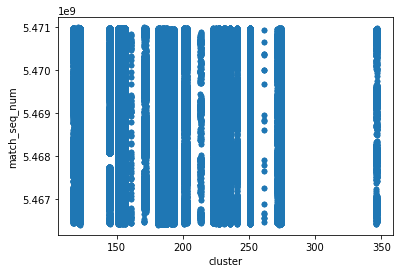

In [20]:
fig, ax = plt.subplots()
for cluster, group in mega_df.groupby("cluster"):
    ax = group.plot("cluster", "match_seq_num", kind="scatter", ax=ax)
# aight I'm kinda interested in cluster 1 but otherwise it looks like these don't have anything to do with match sequence

I later remembered the .hist plot, which would have made more sense. Anyway, here I plotted the cluster number against the match sequence number. If the database was making the clusters, I assumed they would be related to time and thus related to the sequence that matches became available. There was absolutely no useful correlation, so time for a new hypothesis. I checked out that "1" cluster that we can see on the left of the graph on Dotabuff. (While rerunning the notebook to submit, that row somehow disappeared. Trust me, there was one row with cluster of 1)

In [21]:
mega_df[mega_df["cluster"] == 1]

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster


Turned out that the region for that match was "Unknown", which made me think it might be region. Spat out a match for each cluster value and they all seemed to correlate perfectly with the regions Dotabuff gave for the matchIDs. Used that to manually figure out the regions for each cluster (listed in the comments of the code below, the markdown would take way too much space with line spacing)

In [22]:
for cluster in mega_df["cluster"].unique():
    match = mega_df[mega_df["cluster"] == cluster].sample(1)["match_id"].values[0]
    print("Cluster: {cluster:n}\tMatch: {match:n}".format(cluster=cluster, match=match))
# I sampled four of these and they were all in Peru, so it seems likely that cluster describes region
# Cluster 1 is Unknown
# Cluster 251 is Peru
# Cluster 236 is China
# Cluster 144 is South Korea
# Cluster 184 is Russia
# Cluster 155 is SE Asia
# Cluster 117 is US West
# Cluster 273 is Europe
# Cluster 156 is SE Asia (dupe 155)
# Cluster 121 is US East
# Cluster 182 is Russia (dupe 184)
# Cluster 225 is China (dupe 236)
# Cluster 118 is US West (dupe 117)
# Cluster 227 is China (dupe 236)
# Cluster 153 is SE Asia (dupe 155)
# Cluster 122 is US East (dupe 121)
# Cluster 181 is Russia (dupe 184)
# Cluster 241 is Chile
# Cluster 151 is SE Asia (dupe 155)
# Cluster 346 is Unknown
# Cluster 154 is SE Asia (dupe 155)
# Cluster 152 is SE Asia (dupe 155)
# Cluster 274 is Europe (dupe 273)
# Cluster 232 is China (dupe 236)
# Cluster 201 is South America
# Cluster 185 is Russia (dupe 184)
# Cluster 223 is China (dupe 236)
# Cluster 188 is Russia (dupe 184)
# Cluster 202 is South America (dupe 201)
# Cluster 172 is Australia
# Cluster 186 is Russia (dupe 184)
# Cluster 347 is Unknown
# Cluster 231 is China (dupe 236)
# Cluster 187 is Russia (dupe 184)
# Cluster 203 is South America (dupe 201)
# Cluster 171 is Australia (dupe 172)
# Cluster 145 is South Korea (dupe 144)
# Cluster 183 is Russia (dupe 184)
# Cluster 271 is Europe (273)
# Cluster 192 is Europe East
# Cluster 191 is Europe East (dupe 192)
# Cluster 193 is Europe East (dupe 192)
# Cluster 213 is South Africa
# Cluster 161 is Dubai
# Cluster 261 is India
# Cluster 214 is South Africa (dupe 213)

Cluster: 193	Match: 6545870501
Cluster: 251	Match: 6547564915
Cluster: 152	Match: 6544846202
Cluster: 227	Match: 6544689312
Cluster: 188	Match: 6548612418
Cluster: 182	Match: 6546863112
Cluster: 184	Match: 6548934505
Cluster: 185	Match: 6545188316
Cluster: 273	Match: 6548151705
Cluster: 192	Match: 6545613602
Cluster: 187	Match: 6546849507
Cluster: 236	Match: 6546620816
Cluster: 121	Match: 6546963217
Cluster: 274	Match: 6548616101
Cluster: 186	Match: 6545053319
Cluster: 181	Match: 6546262602
Cluster: 183	Match: 6544949515
Cluster: 241	Match: 6547124408
Cluster: 191	Match: 6547129101
Cluster: 155	Match: 6548701604
Cluster: 346	Match: 6548957814
Cluster: 156	Match: 6546221103
Cluster: 201	Match: 6545294812
Cluster: 154	Match: 6544089910
Cluster: 231	Match: 6544932407
Cluster: 225	Match: 6544865101
Cluster: 153	Match: 6546789808
Cluster: 122	Match: 6544269003
Cluster: 232	Match: 6545128815
Cluster: 202	Match: 6548934900
Cluster: 151	Match: 6545975206
Cluster: 145	Match: 6548467017
Cluster:

I imported `re` because I wanted to parse my manually-scribed data into a dict so I could use it to create a region column. I copied and pasted the comments from the above code block into a multi-line string, parsed the lines for cluster number and region, and mapped the two together in a dict.

In [23]:
import re

# I manually checked all of those regions in Dotabuff (an online tool for Dota 2 data and statistics)
region_string= """# Cluster 1 is Unknown
# Cluster 251 is Peru
# Cluster 236 is China
# Cluster 144 is South Korea
# Cluster 184 is Russia
# Cluster 155 is SE Asia
# Cluster 117 is US West
# Cluster 273 is Europe
# Cluster 156 is SE Asia
# Cluster 121 is US East
# Cluster 182 is Russia
# Cluster 225 is China
# Cluster 118 is US West
# Cluster 227 is China
# Cluster 153 is SE Asia
# Cluster 122 is US East
# Cluster 181 is Russia
# Cluster 241 is Chile
# Cluster 151 is SE Asia
# Cluster 346 is Unknown
# Cluster 154 is SE Asia
# Cluster 152 is SE Asia
# Cluster 274 is Europe
# Cluster 232 is China
# Cluster 201 is South America
# Cluster 185 is Russia
# Cluster 223 is China
# Cluster 188 is Russia
# Cluster 202 is South America
# Cluster 172 is Australia
# Cluster 186 is Russia
# Cluster 347 is Unknown
# Cluster 231 is China
# Cluster 187 is Russia
# Cluster 203 is South America
# Cluster 171 is Australia
# Cluster 145 is South Korea
# Cluster 183 is Russia
# Cluster 271 is Europe
# Cluster 192 is Europe East
# Cluster 191 is Europe East
# Cluster 193 is Europe East
# Cluster 213 is South Africa
# Cluster 161 is Dubai
# Cluster 261 is India
# Cluster 214 is South Africa"""

cluster_regions = {}
region_lines = region_string.splitlines()
for line in region_lines:
    search = re.search(r"(?P<cluster>\d{1,3}) is (?P<location>.+)", line)
    cluster = search.group("cluster")
    location = search.group("location")
    cluster_regions[cluster] = location

Now we can see the region for each cluster number in this dict.

In [24]:
cluster_regions

{'1': 'Unknown',
 '251': 'Peru',
 '236': 'China',
 '144': 'South Korea',
 '184': 'Russia',
 '155': 'SE Asia',
 '117': 'US West',
 '273': 'Europe',
 '156': 'SE Asia',
 '121': 'US East',
 '182': 'Russia',
 '225': 'China',
 '118': 'US West',
 '227': 'China',
 '153': 'SE Asia',
 '122': 'US East',
 '181': 'Russia',
 '241': 'Chile',
 '151': 'SE Asia',
 '346': 'Unknown',
 '154': 'SE Asia',
 '152': 'SE Asia',
 '274': 'Europe',
 '232': 'China',
 '201': 'South America',
 '185': 'Russia',
 '223': 'China',
 '188': 'Russia',
 '202': 'South America',
 '172': 'Australia',
 '186': 'Russia',
 '347': 'Unknown',
 '231': 'China',
 '187': 'Russia',
 '203': 'South America',
 '171': 'Australia',
 '145': 'South Korea',
 '183': 'Russia',
 '271': 'Europe',
 '192': 'Europe East',
 '191': 'Europe East',
 '193': 'Europe East',
 '213': 'South Africa',
 '161': 'Dubai',
 '261': 'India',
 '214': 'South Africa'}

Here I am iterating through two million rows of a dataframe to map this stuff. Does pandas have an amazing and idiomatic way to do this? Certainly. Do I have the time to look it up? Certainly not. Code takes around 2-3 minutes to run but it does the job and it's only gotta do it once.

In [25]:
region = []
for index, row in mega_df.iterrows():
    region.append(cluster_regions[str(int(row["cluster"]))])
# mega_df["region"] = cluster_regions[mega_df["cluster"].as_int().as_str()]

In [26]:
mega_df["region"] = region
mega_df.sample(5)

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,region
129264,6546234516,5468361763,False,1651221705,2309,1168.0,1.0,7,22,24,3,182,Russia
235566,6548110111,5470031033,False,1651321859,2522,NaN,NaN,7,22,13,3,188,Russia
197067,6547387408,5469376043,True,1651279966,1922,NaN,NaN,7,22,33,5,192,Europe East
274583,6548786510,5470629116,False,1651347218,2922,3513.0,3.0,7,22,53,6,273,Europe
177745,6547109613,5469125705,False,1651259414,2309,2506.0,1.0,7,22,34,4,184,Russia


Now I turned my attention to num_mmr. No idea what it was, but here's me checking its relation to other data to try and figure it out.

<AxesSubplot:xlabel='avg_mmr', ylabel='num_mmr'>

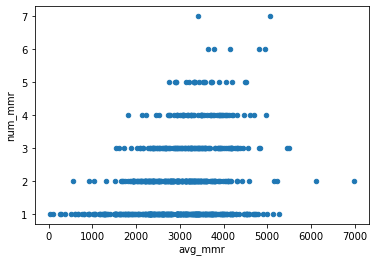

In [27]:
# probably the number of players with a rank that it's calculating from? nope.
# let me see if num_mmr is correlated with avg_mmr to get a hint
sample = mega_df.sample(1000)
sample.plot("avg_mmr", "num_mmr", kind="scatter")

287

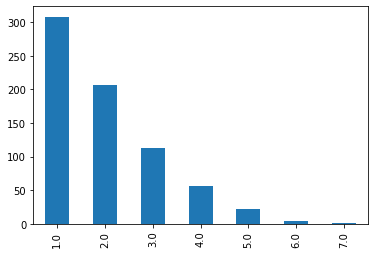

In [28]:
# okay this is interesting. I know the underlying distribution of mmr is roughly normal. 
# So almost any level of match can be a "num_mmr" 1 match
# I think I need to know the distribution of these num_mmrs
sample["num_mmr"].value_counts().plot(kind="bar")
sample["num_mmr"].isna().sum()

<AxesSubplot:xlabel='num_mmr', ylabel='duration'>

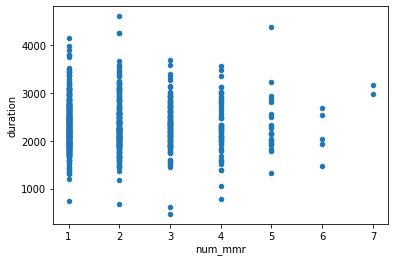

In [29]:
# interesting. So it's... I can't really think of a quantity this is likely to represent based on how it correlates with mmr.
# maybe it has something to do with smurf detection?
# or maybe rank spread (higher spread = bigger number?) so far doesn't seem related to spread
# let's see if there's a relationship with match time. smurfs usually have shorter matches because they stomp
sample.plot("num_mmr", "duration", kind="scatter")

<AxesSubplot:xlabel='num_mmr', ylabel='duration'>

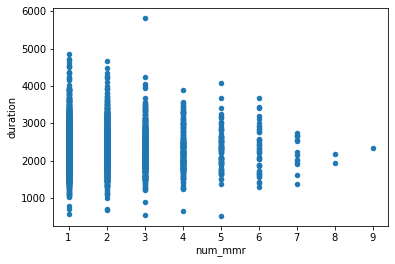

In [30]:
# need a bigger sample
sample2 = mega_df.sample(5000)
sample2.plot("num_mmr", "duration", kind="scatter")

In [31]:
# okay that kinda looks a lot like a relationship so maybe there's something to the smurf theory?
# I'm going to make a reddit post and ask if anyone knows what this field describes
mega_df[mega_df["num_mmr"] == 10.] # kinda rare

,match_id,match_seq_num,radiant_win,start_time,duration,avg_mmr,num_mmr,lobby_type,game_mode,avg_rank_tier,num_rank_tier,cluster,region
124982,6546156010,5468295617,True,1651216280,2018,5778.0,10.0,1,2,80,10,155,SE Asia
191249,6547301017,5469305678,True,1651271086,2427,3215.0,10.0,1,2,58,10,122,US East
197646,6547392407,5469391006,True,1651280876,2096,3846.0,10.0,1,2,79,10,121,US East
199719,6547431506,5469446011,False,1651284269,2918,3846.0,10.0,1,2,79,10,122,US East
266704,6548663103,5470517693,False,1651341722,2293,4960.0,10.0,9,2,77,10,274,Europe
124982,6546156010,5468295617,True,1651216280,2018,5778.0,10.0,1,2,80,10,155,SE Asia
191249,6547301017,5469305678,True,1651271086,2427,3215.0,10.0,1,2,58,10,122,US East
197646,6547392407,5469391006,True,1651280876,2096,3846.0,10.0,1,2,79,10,121,US East
199719,6547431506,5469446011,False,1651284269,2918,3846.0,10.0,1,2,79,10,122,US East
266704,6548663103,5470517693,False,1651341722,2293,4960.0,10.0,9,2,77,10,274,Europe


At this point I had no idea what it was other than possibly that it had to do with some outdated setting to make MMR visible to third parties? I should have just said something wrong and then I bet reddit would have been super helpful. It was at this point that I figured I knew enough about the columns and could begin to quality check the data. Here I list how many null values each column has. We can see that I only have nulls for avg_ and num_mmr, and exactly the same number. Useful.

In [32]:
mega_df.isnull().sum()
# okay so we got ~850k games with no rank data
# everything else is fine

match_id              0
match_seq_num         0
radiant_win           0
start_time            0
duration              0
avg_mmr          384684
num_mmr          384684
lobby_type            0
game_mode             0
avg_rank_tier         0
num_rank_tier         0
cluster               0
region                0
dtype: int64

Here we can see that ~29% of ranked matches do not have an average mmr listed, which is very strange. I also noticed that unranked matches do have an mmr variable sometimes, but that's fine with my understanding. There is a "hidden mmr" for your unranked matches to make sure new players don't match with actual professionals.

In [33]:
num_ranked_without_mmr = mega_df[mega_df["lobby_type"] == 7].isnull().sum()["avg_mmr"]
num_ranked_total = len(mega_df[mega_df["lobby_type"] == 7])
print("Number of Total Ranked Matches: " + str(num_ranked_total))
print("Number of Ranked Matches Without MMR: " + str(num_ranked_without_mmr))
num_ranked_without_mmr / num_ranked_total
# 29% of ranked matches have no mmr here

Number of Total Ranked Matches: 967492
Number of Ranked Matches Without MMR: 286136


0.29575024909766695

Made a dataframe for ranked games and ranked games with avg_mmr shown.

In [34]:
ranked_df = mega_df[mega_df["lobby_type"] == 7].copy()
ranked_with_mmr_df = ranked_df[ranked_df["avg_mmr"].notna()].copy()

Now I simply visualize the distributions of various columns to draw conclusions from them.

<AxesSubplot:ylabel='ones'>

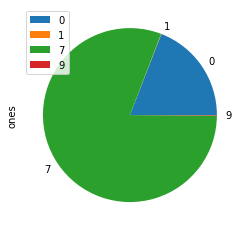

In [35]:
# gotta add a col of 1s so I can plot this
distribution_df = mega_df.copy()
distribution_df["ones"] = 1
distribution_df.groupby(['lobby_type']).sum().plot(kind="pie", y="ones")
# if we check this without plotting we can see that there are a combined total of ~3k matches out of 3 million in lobby types 1 and 9 (tournaments and battle cups)

<AxesSubplot:ylabel='ones'>

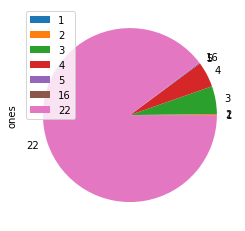

In [36]:
# plot of distributions of game mode
distribution_df.groupby(['game_mode']).sum().plot(kind="pie", y="ones")

<AxesSubplot:ylabel='ones'>

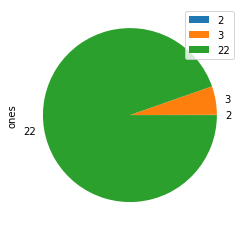

In [37]:
# plot of distributions of game mode - lobby type (e.g. different category for ranked all pick and unranked all pick)
# so with 4 lobby types and 7 different gamemodes we have a theoretical max of 28 possible game-lobby types
# ranked_distribution_df = ranked_df.copy()
distribution_df[distribution_df["lobby_type"] == 7].groupby(['game_mode']).sum().plot(kind="pie", y="ones")
# gamemodes in ranked

<AxesSubplot:ylabel='ones'>

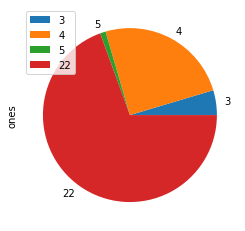

In [38]:
distribution_df[distribution_df["lobby_type"] == 0].groupby(['game_mode']).sum().plot(kind="pie", y="ones")
# gamemodes in unranked
# okay this is kinda neat actually, low prio is single draft and that's like 25% of matches

In [39]:
#distribution_df.groupby(['avg_rank_tier']).sum().plot(kind="pie", y="ones") 
# seems kinda even but also a PITA to format

<AxesSubplot:ylabel='ones'>

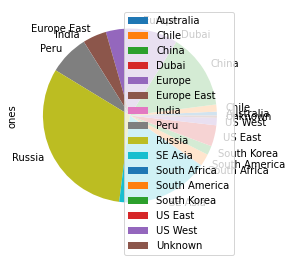

In [40]:
distribution_df.groupby(['region']).sum().plot(kind="pie", y="ones")
# gonna want to polish this plot but it's useful. Lots of Russia, lots of SEA, lots of China.

Here we can see a histogram of the distribution of avg_mmr. Exactly as expected, it's a normal curve witb a center around ~3000, the average global rank. I also plotted histograms for unranked mmr and ranked mmr, which were interestingly the same. Slight right skew to account for the professionals who end up with MMR around 10k regularly, while the floor of 0 MMR keeps the worst players from skewing the graph left.

array([[<AxesSubplot:title={'center':'avg_mmr'}>]], dtype=object)

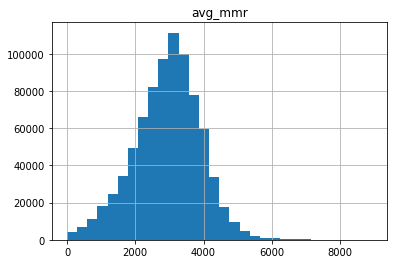

In [41]:
# I already kinda know the distribution of mmr but let's plot it
# violin plot.

# make a dict from x-category to values


# fig, ax = plt.subplots()
# ax.violinplot(data, widths=1, showmeans=True)

# okay check this, plot with x = mmr, y = frequency
# one for unranked with ranks one for ranked with ranks
distribution_df.hist("avg_mmr", bins=30)
# could optimize this with buckets, might be a PITA to label like this
# nah just use hist

array([[<AxesSubplot:title={'center':'avg_mmr'}>]], dtype=object)

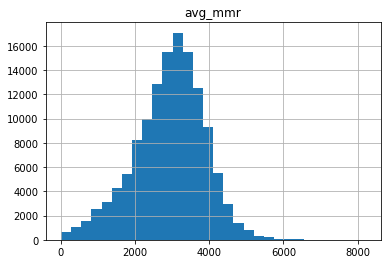

In [42]:
# distribution_df[distribution_df["lobby_type"] == 0].groupby(["avg_mmr"]).sum().hist("avg_mmr", bins=20)
distribution_df[distribution_df["lobby_type"] == 0].hist("avg_mmr", bins=30)

array([[<AxesSubplot:title={'center':'avg_mmr'}>]], dtype=object)

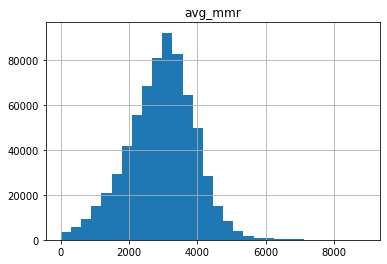

In [43]:
distribution_df[distribution_df["lobby_type"] == 7].hist("avg_mmr", bins=30)
# extremely similar distribution of mmr between ranked and unranked, with a notably longer tail on ranked games

array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

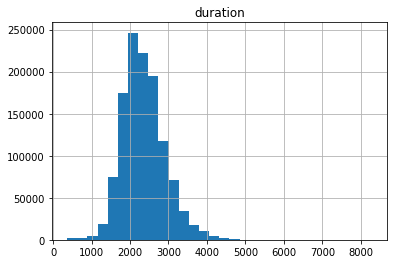

In [44]:
distribution_df.hist("duration", bins=30)
# right-skewed, makes sense. It's physically difficult to end a game before a certain time even if the enemies are basically helping you.